In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

In [24]:
# getting data
interaction_train = pd.read_csv("C:/Users/HOME/문서/한양대/3-2/산업공학연구실현장실습2/datas/Instacart/interactions_train.csv",index_col=0)
interaction_valid = pd.read_csv("C:/Users/HOME/문서/한양대/3-2/산업공학연구실현장실습2/datas/Instacart/interactions_valid.csv",index_col=0)
sample_weight_train = pd.Series.from_csv("C:/Users/HOME/문서/한양대/3-2/산업공학연구실현장실습2/datas/Instacart/sample_weight_train.csv",index_col=0)
sample_weight_valid = pd.Series.from_csv("C:/Users/HOME/문서/한양대/3-2/산업공학연구실현장실습2/datas/Instacart/sample_weight_valid.csv",index_col=0)

In [25]:
# sample_weight_train = sample_weight_train['orders']
# sample_weight_valid = sample_weight_valid['orders']

##### Initialize the model

In [26]:
model = RankFM(factors=50, loss='warp', max_samples=50, alpha=0.01, learning_rate=0.1, learning_schedule='invscaling')

##### Fit the model

In [27]:
model.fit(interaction_train, sample_weight=sample_weight_train, epochs=30, verbose=True)


training epoch: 0
log likelihood: -278375.625

training epoch: 1
log likelihood: -272229.53125

training epoch: 2
log likelihood: -263574.1875

training epoch: 3
log likelihood: -256180.109375

training epoch: 4
log likelihood: -248548.75

training epoch: 5
log likelihood: -242395.921875

training epoch: 6
log likelihood: -237254.828125

training epoch: 7
log likelihood: -233736.40625

training epoch: 8
log likelihood: -231136.0625

training epoch: 9
log likelihood: -228616.3125

training epoch: 10
log likelihood: -226942.421875

training epoch: 11
log likelihood: -225422.484375

training epoch: 12
log likelihood: -223369.171875

training epoch: 13
log likelihood: -222447.375

training epoch: 14
log likelihood: -220678.96875

training epoch: 15
log likelihood: -220290.515625

training epoch: 16
log likelihood: -218978.734375

training epoch: 17
log likelihood: -217909.828125

training epoch: 18
log likelihood: -217328.96875

training epoch: 19
log likelihood: -216759.59375

training e

In [29]:
scores = model.predict(interaction_valid, cold_start='nan')
scores

array([5.7029123 , 4.3384643 , 5.258583  , ..., 2.0875874 , 2.8852053 ,
       0.44722572], dtype=float32)

##### Genereate top recommendations

In [33]:
train_users = pd.Series(interaction_train.user_id.unique())
valid_users = pd.Series(interaction_valid.user_id.unique())
both_users  = set(train_users)&set(valid_users)

len(train_users), len(valid_users), len(both_users)

(10000, 9931, 9931)

In [34]:
valid_recs = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')
valid_recs.head()

,0,1,2,3,4,5,6,7,8,9
15,12427,37710,196,31651,11266,38928,46149,6184,13575,11759
47,15902,24852,43772,16797,28199,27966,27360,48527,21137,26604
58,39993,46041,24852,27323,5025,23888,23734,34969,7295,4605
83,21137,24852,13740,4920,27344,13176,16797,44560,28204,27086
102,24852,47626,47766,21137,13176,49683,26209,4920,42265,47209


#### Evaluationg Model

In [35]:
k = 10
most_popular = interaction_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

product_id
24852    3332
13176    2829
21137    2538
21903    2450
47626    2004
26209    1926
47209    1878
16797    1857
47766    1851
39275    1495
Name: user_id, dtype: int64

In [39]:
test_user_items = interaction_valid.groupby('user_id')['product_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

In [40]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 9931
baseline hit rate: 0.602
baseline precision: 0.132
baseline recall: 0.059


##### Generating model performance validation metrics

In [42]:
model_hrt = hit_rate(model, interaction_valid, k=k)
model_rnk = reciprocal_rank(model, interaction_valid, k=k)
model_pre = precision(model, interaction_valid, k=k)
model_rec = recall(model, interaction_valid, k=k)

In [44]:
print("model hit rate: {}".format(round(model_hrt, 3)))
print("model reciprocal rank: {}".format(round(model_rnk, 3)))
print("model precision: {}".format(round(model_pre, 3)))
print("model recall: {}".format(round(model_rec, 3)))

model hit rate: 0.794
model reciprocal rank: 0.475
model precision: 0.23
model recall: 0.123


##### Assessing diversity of recommendations

In [45]:
products_df = pd.read_csv("C:/Users/HOME/문서/한양대/3-2/산업공학연구실현장실습2/datas/Instacart/products.csv",index_col=0)
products_df

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13
...,...,...,...
49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49685,En Croute Roast Hazelnut Cranberry,42,1
49686,Artisan Baguette,112,3


In [46]:
model_diversity = diversity(model, interaction_valid, k=k).rename({'item_id': 'product_id'}, axis=1)
model_diversity = pd.merge(model_diversity, products_df, on='product_id', how='inner')
model_diversity = model_diversity[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
model_diversity.head(20)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,6581,0.662672,24852,Banana,24,4
1,5652,0.569127,13176,Bag of Organic Bananas,24,4
2,4650,0.468231,21903,Organic Baby Spinach,123,4
3,3923,0.395026,21137,Organic Strawberries,24,4
4,3614,0.363911,47209,Organic Hass Avocado,24,4
5,3013,0.303393,16797,Strawberries,24,4
6,2811,0.283053,47626,Large Lemon,24,4
7,2739,0.275803,26209,Limes,24,4
8,2573,0.259088,47766,Organic Avocado,24,4
9,2272,0.228779,49683,Cucumber Kirby,83,4


In [47]:
coverage = np.mean(model_diversity.cnt_users > 0)
round(coverage, 3)

0.154

In [48]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

43.82

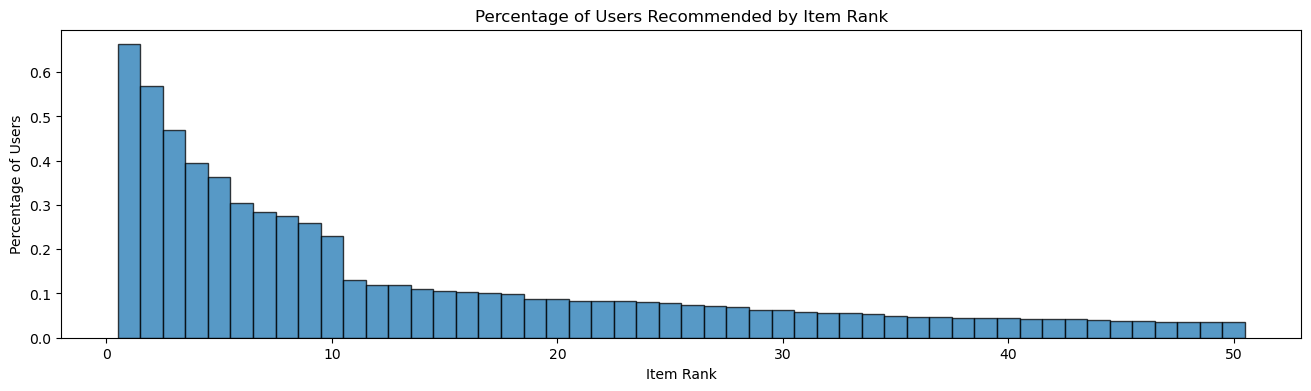

In [49]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()